## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

В начале остановимся на наиболее перспективных навыках

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")

/tmp/ipykernel_161731/2175504698.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("ConnectionTime.csv")


## Рассмотрим датасет по ближе

In [3]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [4]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [5]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [6]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [7]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [8]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0


Узнаем размерность наборов

In [9]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_test (262, 2)


### Видоизмение данных

Обьединим два набора с данными

In [10]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ1-02783,2,ОРГ1-01974,Высшее образование,Автоматизация технологических процессов и прои...
3,ОРГ2-06173,0,ОРГ2-01170,Высшее образование,Управление качеством


In [11]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)

df_train["Вид образования"].value_counts()

Высшее образование                                297
Среднее профессиональное образование               64
Высшее образование - бакалавриат                   59
Высшее образование - специалитет, магистратура     30
Начальное профессиональное образование              7
Повышение квалификации                              7
Неполное высшее образование                         5
Среднее общее образование                           3
Среднее (полное) общее образование                  2
Переподготовка                                      2
Профессиональное обучение                           1
Name: Вид образования, dtype: int64

In [12]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

df_train["Вид образования"].value_counts()

 0     297
-1      73
 10     64
 1      59
 2      30
 3       7
 6       7
 4       5
 9       3
 8       2
 5       2
 7       1
Name: Вид образования, dtype: int64

Оставим только столбец - опоздания сотрудников

In [13]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [14]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})

df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [15]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,4,5.0
1,ОРГ1-02783,2,0,7.0
2,ОРГ2-06173,0,0,22.0


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               550 non-null    object 
 1   type             550 non-null    int64  
 2   Вид образования  550 non-null    int8   
 3   Число опозданий  491 non-null    float64
dtypes: float64(1), int64(1), int8(1), object(1)
memory usage: 17.7+ KB


## Добавим суммарное время звонков!



In [17]:
def str_to_float(str):
    if type(str)==float:
        return str
    str=str.replace(',','')
    return float(str)

df_calls['CallTime']=df_calls['CallTime'].map(str_to_float)
CallTime=pd.DataFrame(df_calls.groupby('id')['CallTime'].sum()).reset_index()
df_train = pd.merge(df_train, CallTime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime
0,ОРГ1-02050,2,4,5.0,4.810983e+18
1,ОРГ1-02783,2,0,7.0,1.350599e+19
2,ОРГ2-06173,0,0,22.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17
...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19
547,ОРГ1-02862,2,-1,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19


In [18]:
df_calls['NumberOfCalls'].value_counts()

1      140167
2       60780
3       33555
4       27493
5       19761
        ...  
107         1
105         1
114         1
98          1
95          1
Name: NumberOfCalls, Length: 102, dtype: int64

## Добавим колличество звонков в будни и выходные

In [19]:
NumberOfCalls=pd.DataFrame(df_calls.groupby('id')['NumberOfCalls'].sum()).reset_index()
df_calls= df_calls.rename(columns={'Вид учета времени': 'statusworkfre'})
NumberOfCallsW=pd.DataFrame(df_calls.query("statusworkfre=='Будни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberOfCallsNW=pd.DataFrame(df_calls.query("statusworkfre=='Выходные дни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
df_train = pd.merge(df_train, NumberOfCalls , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsW , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsNW , on="id", how='left')
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN
...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0


## Добавим колличество входящих и исходящих.

In [20]:
NumberToUser=pd.DataFrame(df_calls.query("InOut=='ToUser'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberFromUser=pd.DataFrame(df_calls.query("InOut=='FromUser'").groupby('id')['NumberOfCalls'].sum()).reset_index() 
df_train = pd.merge(df_train, NumberToUser , on="id", how='left')
df_train = pd.merge(df_train, NumberFromUser , on="id", how='left')

/tmp/ipykernel_161731/762760274.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'NumberOfCalls_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_train = pd.merge(df_train, NumberToUser , on="id", how='left')


## Добавим суммарное время опазданий

In [21]:
df_connection_time['Время опоздания']=df_connection_time['Время опоздания'].map(str_to_float)
falout=pd.DataFrame(df_connection_time.groupby('id')['Время опоздания'].sum()).reset_index() 
df_train = pd.merge(df_train, falout , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17
...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17


## Добавим дельту прихода на работу

In [22]:
df_connection_time['Нормативное время начала раб.дня']=pd.to_datetime(df_connection_time['Нормативное время начала раб.дня'])
df_connection_time['Фактич. время начала раб.дня']=pd.to_datetime(df_connection_time['Фактич. время начала раб.дня'])
df_connection_time['filtime']=df_connection_time['Нормативное время начала раб.дня']-df_connection_time['Фактич. время начала раб.дня']
filtime=pd.DataFrame(df_connection_time.groupby('id')['filtime'].mean().dt.total_seconds()).reset_index()
df_train = pd.merge(df_train, filtime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания,filtime
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892
...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964


## Заменим пропуски на нули

In [23]:
df_train = df_train.fillna(0)

In [24]:
df_train.append(df_train)

/tmp/ipykernel_161731/1736593577.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train.append(df_train)


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания,filtime
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,0.0,176.0,370.0,2.361381e+17,276.332096
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,0.0,657.0,1245.0,2.532397e+17,-695.247628
2,ОРГ2-06173,0,0,22.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.200253e+18,-608.828839
3,ОРГ2-05359,2,10,6.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.657396e+17,2186.244912
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,0.0,1.0,6.0,9.288578e+17,-14381.555892
...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864
547,ОРГ1-02862,2,-1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964


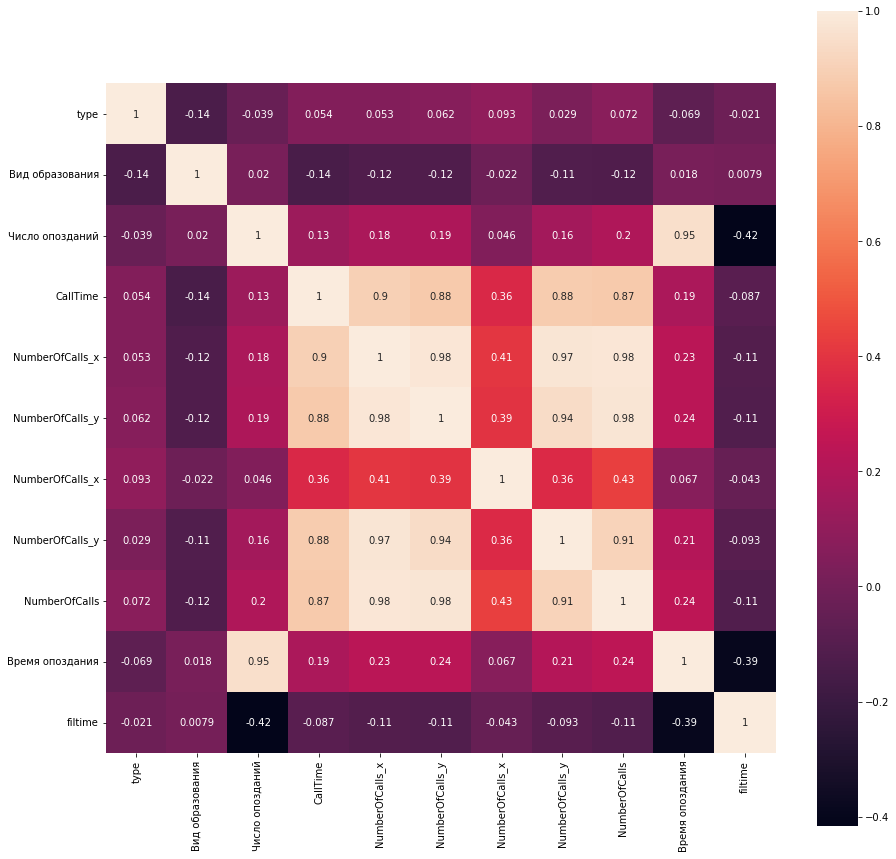

In [25]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [26]:
X = df_train.drop(["id", "type"], axis = 1)
y = df_train["type"]

# Стандартизация величин!

In [27]:
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 0.73843104, -0.63704669, -0.26130887, ..., -0.27593855,
        -0.74128568,  0.49142369],
       [-0.44650572, -0.6014954 ,  0.54960802, ...,  0.40400711,
        -0.73366303,  0.25695745],
       [-0.44650572, -0.33486077, -0.70999231, ..., -0.56345842,
        -0.31155285,  0.27781244],
       ...,
       [-0.74273991, -0.7259249 , -0.70999231, ..., -0.56345842,
        -0.84653898,  0.42473791],
       [-0.74273991, -0.51261719,  0.92183569, ...,  1.63490301,
        -0.60361858,  0.41066772],
       [-0.74273991, -0.7259249 , -0.6979493 , ..., -0.56112718,
        -0.84653898,  0.42473791]])

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Вид образования  550 non-null    int8   
 1   Число опозданий  550 non-null    float64
 2   CallTime         550 non-null    float64
 3   NumberOfCalls_x  550 non-null    float64
 4   NumberOfCalls_y  550 non-null    float64
 5   NumberOfCalls_x  550 non-null    float64
 6   NumberOfCalls_y  550 non-null    float64
 7   NumberOfCalls    550 non-null    float64
 8   Время опоздания  550 non-null    float64
 9   filtime          550 non-null    float64
dtypes: float64(9), int8(1)
memory usage: 43.5 KB


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Обучение модели

In [31]:
clf = RandomForestClassifier(min_samples_leaf=1,min_samples_split= 4,n_estimators= 10,random_state=0,n_jobs=-1)


parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [32]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_split=4, n_estimators=10,
                       n_jobs=-1, random_state=0)

## Оценка точности

In [33]:
pred = clf.predict(X_test)

In [34]:
y_test.head(3)

195    2
79     2
480    0
Name: type, dtype: int64

In [35]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.22598522167487686


In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.27      0.21      0.24        14
           1       0.00      0.00      0.00         8
           2       0.50      0.69      0.58        29
           3       0.00      0.00      0.00         4

    accuracy                           0.42        55
   macro avg       0.19      0.23      0.20        55
weighted avg       0.33      0.42      0.37        55



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Генерация предсказания

In [ ]:
df_test

## Добавим фичи.

In [ ]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_test = df_test.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_test["Вид образования"] = df_test["Вид образования"].astype('category')
df_test["Вид образования"] = df_test["Вид образования"].cat.codes
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

# Добавим суммарное время звоков

In [ ]:
df_test = pd.merge(df_test, CallTime , on="id", how='left')

## Добавим колличество звонков в будни и выходные дни

In [ ]:
df_test = pd.merge(df_test, NumberOfCalls , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsW , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsNW , on="id", how='left')

## Добавим колличество входящих и исходящих

In [ ]:
df_test = pd.merge(df_test, NumberToUser , on="id", how='left')
df_test = pd.merge(df_test, NumberFromUser , on="id", how='left')

# Добавим суммарное время опоздания

In [ ]:
df_test = pd.merge(df_test, falout , on="id", how='left')

# Добавим дельту прихода на работу

In [ ]:
df_test = pd.merge(df_test, filtime , on="id", how='left')

# Удалим пустые значения

In [ ]:
df_test = df_test.fillna(0)

## Предсказания

In [ ]:
df_test_pred = pd.read_csv("test.csv")
Xpred = df_test.drop(["id", "type"], axis = 1)
scaler.transform(Xpred)
preds = clf.predict(Xpred)
df_test_pred['type']=preds

In [ ]:
df_test_pred.to_csv('rfnev.csv', index=False)

In [ ]:
df_test_pred['type'].value_counts()